In [1]:
from pycalphad.model import TestModel
import pycalphad
import pycalphad.variables as v
from pycalphad.core.halton import halton
import numpy as np
rng = np.random.RandomState(1769)

In [2]:
def sample_quasi(comp_count, pdof=10):
    """
    Sample 'pdof * (sum(comp_count) - len(comp_count))' points in
    composition space for the sublattice configuration specified
    by 'comp_count'. Points are sampled quasi-randomly from a Halton sequence.
    A Halton sequence is like a uniform random distribution, but the
    result will always be the same for a given 'comp_count' and 'pdof'.
    Note: For systems with only one component, only one point will be
    returned, regardless of 'pdof'. This is because the degrees of freedom
    are zero for that case.

    Parameters
    ----------
    comp_count : list
        Number of components in each sublattice.
    pdof : int
        Number of points to sample per degree of freedom.

    Returns
    -------
    ndarray of generated points satisfying the mass balance.

    Examples
    --------
    >>> comps = [8,1] # 8 components in sublattice 1; only 1 in sublattice 2
    >>> pts = point_sample(comps, pdof=20) # 7 d.o.f, returns a 140x7 ndarray
    """
    # Generate Halton sequence with appropriate dimensions and size
    pts = halton(sum(comp_count),
                 pdof * (sum(comp_count) - len(comp_count)), scramble=True)
    # Convert low-discrepancy sequence to normalized exponential
    # This will be uniformly distributed over the simplices
    pts = -np.log(pts)
    cur_idx = 0
    for ctx in comp_count:
        end_idx = cur_idx + ctx
        pts[:, cur_idx:end_idx] /= pts[:, cur_idx:end_idx].sum(axis=1)[:, None]
        cur_idx = end_idx

    if len(pts) == 0:
        pts = np.atleast_2d([1] * len(comp_count))
    return pts
def sample_pseudo(comp_count, pdof=10):
    """
    Sample 'pdof * (sum(comp_count) - len(comp_count))' points in
    composition space for the sublattice configuration specified
    by 'comp_count'. Points are sampled pseudo-randomly from a symmetric
    Dirichlet distribution.
    Note: For systems with only one component, only one point will be
    returned, regardless of 'pdof'. This is because the degrees of freedom
    are zero for that case.

    Parameters
    ----------
    comp_count : list
        Number of components in each sublattice.
    pdof : int
        Number of points to sample per degree of freedom.

    Returns
    -------
    ndarray of generated points satisfying the mass balance.

    Examples
    --------
    >>> comps = [8,1] # 8 components in sublattice 1; only 1 in sublattice 2
    >>> pts = point_sample(comps, pdof=20) # 7 d.o.f, returns a 140x7 ndarray
    """
    # Generate Halton sequence with appropriate dimensions and size
    pts = np.empty((pdof * (sum(comp_count) - len(comp_count)), sum(comp_count), ))
    cur_idx = 0
    for ctx in comp_count:
        end_idx = cur_idx + ctx
        pts[:, cur_idx:end_idx] = rng.dirichlet(np.ones(ctx, dtype=np.int),
                                                size=(pdof * (sum(comp_count) - len(comp_count))))
        cur_idx = end_idx
    if len(pts) == 0:
        pts = np.atleast_2d([1] * len(comp_count))
    return pts
def test_opt(num_components, num_samples, sampler, solutions):
    result_array = np.empty((num_samples))
    comps = ['X{}'.format(str(i+1).zfill(len(str(num_components)))) for i in range(num_components)]
    print('{} COMPONENTS'.format(num_components))
    for idx in range(num_samples):
        print('TRIAL {}/{}'.format(idx+1, num_samples))
        solution = solutions[idx]
        tm = TestModel(None, comps, 'TEST', solution=solution, kmax=2)
        dbf = pycalphad.Database()
        dbf.add_phase('TEST', {}, [1])
        dbf.add_phase_constituents('TEST', [comps])
        conds = {v.P:101325, v.T:300}
        conds.update({v.X(i):sol for i, sol in list(zip(comps, solution))[:-1]})
        grid_opts = {'sampler': sampler, 'pdens': 100}
        eq = pycalphad.equilibrium(dbf, comps, 'TEST', conds, model=tm, verbose=False, grid_opts=grid_opts)
        if eq.GM < 1e-2:
            result_array[idx] = eq.attrs['iterations']
        else:
            print(eq.GM)
            print(eq.X.values)
            print(solution)
            result_array[idx] = np.nan
    return result_array

In [9]:
%%time
comp_iters_pseudo = []
comp_iters_quasi = []
max_comps = 10
num_trials = 20
for num_comps in range(2, max_comps+1):
    solutions = [rng.dirichlet(np.ones(num_comps, dtype=np.int)) for i in range(num_trials)]
    from pycalphad.core.lower_convex_hull import lower_convex_hull, _initialize_array
    print('PSEUDO')
    results_pseudo = test_opt(num_comps, num_trials, sample_pseudo, solutions)
    print('QUASI')
    results_quasi = test_opt(num_comps, num_trials, sample_quasi, solutions)
    comp_iters_pseudo.append(results_pseudo)
    comp_iters_quasi.append(results_quasi)
comp_iters_pseudo = np.array(comp_iters_pseudo, dtype=np.float)
comp_iters_quasi = np.array(comp_iters_quasi, dtype=np.float)

PSEUDO
2 COMPONENTS
TRIAL 1/20
RESIDUAL STEP NORM 0.165378835574
<xarray.Dataset>
Dimensions:       (P: 1, T: 1, X_X1: 1, component: 2, internal_dof: 2, vertex: 2)
Coordinates:
  * P             (P) float64 1.013e+05
  * T             (T) float64 300.0
  * X_X1          (X_X1) float64 0.5841
  * vertex        (vertex) int64 0 1
  * component     (component) object 'X1' 'X2'
  * internal_dof  (internal_dof) int64 0 1
Data variables:
    MU            (P, T, X_X1, component) float64 -4.136e-05 -4.082e-05
    GM            (P, T, X_X1) float64 1.047e-05
    NP            (P, T, X_X1, vertex) float64 0.1712 0.8288
    X             (P, T, X_X1, vertex, component) float64 0.5841 0.4159 ...
    Y             (P, T, X_X1, vertex, internal_dof) float64 0.5841 0.4159 ...
    Phase         (P, T, X_X1, vertex) object 'TEST' 'TEST'
Attributes:
    iterations: 6
TRIAL 2/20
RESIDUAL STEP NORM 5.50409064089
<xarray.Dataset>
Dimensions:       (P: 1, T: 1, X_X1: 1, component: 2, internal_dof: 2, verte

pycalphad ERROR 2016-01-30 09:34:45,924 [lower_convex_hull 267] Iterations exceeded


 490.054174937
RESIDUAL STEP NORM 0.0499534496592
<xarray.Dataset>
Dimensions:       (P: 1, T: 1, X_X1: 1, X_X2: 1, X_X3: 1, X_X4: 1, X_X5: 1, X_X6: 1, X_X7: 1, component: 8, internal_dof: 8, vertex: 8)
Coordinates:
  * P             (P) float64 1.013e+05
  * T             (T) float64 300.0
  * X_X1          (X_X1) float64 0.2286
  * X_X2          (X_X2) float64 0.01903
  * X_X3          (X_X3) float64 0.04406
  * X_X4          (X_X4) float64 0.09744
  * X_X5          (X_X5) float64 0.1531
  * X_X6          (X_X6) float64 0.05824
  * X_X7          (X_X7) float64 0.2742
  * vertex        (vertex) int64 0 1 2 3 4 5 6 7
  * component     (component) object 'X1' 'X2' 'X3' 'X4' 'X5' 'X6' 'X7' 'X8'
  * internal_dof  (internal_dof) int64 0 1 2 3 4 5 6 7
Data variables:
    MU            (P, T, X_X1, X_X2, X_X3, X_X4, X_X5, X_X6, X_X7, component) float64 6.089e-08 ...
    GM            (P, T, X_X1, X_X2, X_X3, X_X4, X_X5, X_X6, X_X7) float64 2.533e-05 ...
    NP            (P, T, X_X1, X_X2, X

pycalphad ERROR 2016-01-30 09:36:43,481 [lower_convex_hull 267] Iterations exceeded


 1.40862678368
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-30 09:36:43,893 [lower_convex_hull 267] Iterations exceeded


 0.83187586422
RESIDUAL STEP NORM 0.0503762789602
<xarray.Dataset>
Dimensions:       (P: 1, T: 1, X_X1: 1, X_X2: 1, X_X3: 1, X_X4: 1, X_X5: 1, X_X6: 1, X_X7: 1, component: 8, internal_dof: 8, vertex: 8)
Coordinates:
  * P             (P) float64 1.013e+05
  * T             (T) float64 300.0
  * X_X1          (X_X1) float64 0.2645
  * X_X2          (X_X2) float64 0.1024
  * X_X3          (X_X3) float64 0.1513
  * X_X4          (X_X4) float64 0.06192
  * X_X5          (X_X5) float64 0.04005
  * X_X6          (X_X6) float64 0.1597
  * X_X7          (X_X7) float64 0.09819
  * vertex        (vertex) int64 0 1 2 3 4 5 6 7
  * component     (component) object 'X1' 'X2' 'X3' 'X4' 'X5' 'X6' 'X7' 'X8'
  * internal_dof  (internal_dof) int64 0 1 2 3 4 5 6 7
Data variables:
    MU            (P, T, X_X1, X_X2, X_X3, X_X4, X_X5, X_X6, X_X7, component) float64 -4.059e-07 ...
    GM            (P, T, X_X1, X_X2, X_X3, X_X4, X_X5, X_X6, X_X7) float64 0.0001098 ...
    NP            (P, T, X_X1, X_X2, X

pycalphad ERROR 2016-01-30 09:37:45,122 [lower_convex_hull 267] Iterations exceeded


 771.109672147
RESIDUAL STEP NORM 0.0426454974687
<xarray.Dataset>
Dimensions:       (P: 1, T: 1, X_X1: 1, X_X2: 1, X_X3: 1, X_X4: 1, X_X5: 1, X_X6: 1, X_X7: 1, X_X8: 1, component: 9, internal_dof: 9, vertex: 9)
Coordinates:
  * P             (P) float64 1.013e+05
  * T             (T) float64 300.0
  * X_X1          (X_X1) float64 0.04117
  * X_X2          (X_X2) float64 0.2919
  * X_X3          (X_X3) float64 0.0529
  * X_X4          (X_X4) float64 0.08356
  * X_X5          (X_X5) float64 0.1644
  * X_X6          (X_X6) float64 0.08268
  * X_X7          (X_X7) float64 0.0605
  * X_X8          (X_X8) float64 0.1663
  * vertex        (vertex) int64 0 1 2 3 4 5 6 7 8
  * component     (component) object 'X1' 'X2' 'X3' 'X4' 'X5' 'X6' 'X7' 'X8' ...
  * internal_dof  (internal_dof) int64 0 1 2 3 4 5 6 7 8
Data variables:
    MU            (P, T, X_X1, X_X2, X_X3, X_X4, X_X5, X_X6, X_X7, X_X8, component) float64 7.912e-08 ...
    GM            (P, T, X_X1, X_X2, X_X3, X_X4, X_X5, X_X6, X_X7

pycalphad ERROR 2016-01-30 09:38:32,616 [lower_convex_hull 267] Iterations exceeded


 1625.99206942
RESIDUAL STEP NORM 0.0207556836154
<xarray.Dataset>
Dimensions:       (P: 1, T: 1, X_X1: 1, X_X2: 1, X_X3: 1, X_X4: 1, X_X5: 1, X_X6: 1, X_X7: 1, X_X8: 1, component: 9, internal_dof: 9, vertex: 9)
Coordinates:
  * P             (P) float64 1.013e+05
  * T             (T) float64 300.0
  * X_X1          (X_X1) float64 0.072
  * X_X2          (X_X2) float64 0.1665
  * X_X3          (X_X3) float64 0.1097
  * X_X4          (X_X4) float64 0.08478
  * X_X5          (X_X5) float64 0.1476
  * X_X6          (X_X6) float64 0.1893
  * X_X7          (X_X7) float64 0.03795
  * X_X8          (X_X8) float64 0.1762
  * vertex        (vertex) int64 0 1 2 3 4 5 6 7 8
  * component     (component) object 'X1' 'X2' 'X3' 'X4' 'X5' 'X6' 'X7' 'X8' ...
  * internal_dof  (internal_dof) int64 0 1 2 3 4 5 6 7 8
Data variables:
    MU            (P, T, X_X1, X_X2, X_X3, X_X4, X_X5, X_X6, X_X7, X_X8, component) float64 -4.375e-07 ...
    GM            (P, T, X_X1, X_X2, X_X3, X_X4, X_X5, X_X6, X_X7,

pycalphad ERROR 2016-01-30 09:39:07,555 [lower_convex_hull 267] Iterations exceeded


 343.130424162
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-30 09:39:09,064 [lower_convex_hull 267] Iterations exceeded


 112.908611773
RESIDUAL STEP NORM 0.0320038868064
<xarray.Dataset>
Dimensions:       (P: 1, T: 1, X_X1: 1, X_X2: 1, X_X3: 1, X_X4: 1, X_X5: 1, X_X6: 1, X_X7: 1, X_X8: 1, component: 9, internal_dof: 9, vertex: 9)
Coordinates:
  * P             (P) float64 1.013e+05
  * T             (T) float64 300.0
  * X_X1          (X_X1) float64 0.05301
  * X_X2          (X_X2) float64 0.04368
  * X_X3          (X_X3) float64 0.1304
  * X_X4          (X_X4) float64 0.03643
  * X_X5          (X_X5) float64 0.03649
  * X_X6          (X_X6) float64 0.08503
  * X_X7          (X_X7) float64 0.09446
  * X_X8          (X_X8) float64 0.3432
  * vertex        (vertex) int64 0 1 2 3 4 5 6 7 8
  * component     (component) object 'X1' 'X2' 'X3' 'X4' 'X5' 'X6' 'X7' 'X8' ...
  * internal_dof  (internal_dof) int64 0 1 2 3 4 5 6 7 8
Data variables:
    MU            (P, T, X_X1, X_X2, X_X3, X_X4, X_X5, X_X6, X_X7, X_X8, component) float64 -6.911e-08 ...
    GM            (P, T, X_X1, X_X2, X_X3, X_X4, X_X5, X_X6, 

pycalphad ERROR 2016-01-30 09:40:47,549 [lower_convex_hull 267] Iterations exceeded


 0.00336438597651
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-30 09:40:48,091 [lower_convex_hull 267] Iterations exceeded


 0.00333923075709
RESIDUAL STEP NORM 0.0241859570435
<xarray.Dataset>
Dimensions:       (P: 1, T: 1, X_X1: 1, X_X2: 1, X_X3: 1, X_X4: 1, X_X5: 1, X_X6: 1, X_X7: 1, X_X8: 1, component: 9, internal_dof: 9, vertex: 9)
Coordinates:
  * P             (P) float64 1.013e+05
  * T             (T) float64 300.0
  * X_X1          (X_X1) float64 0.04117
  * X_X2          (X_X2) float64 0.2919
  * X_X3          (X_X3) float64 0.0529
  * X_X4          (X_X4) float64 0.08356
  * X_X5          (X_X5) float64 0.1644
  * X_X6          (X_X6) float64 0.08268
  * X_X7          (X_X7) float64 0.0605
  * X_X8          (X_X8) float64 0.1663
  * vertex        (vertex) int64 0 1 2 3 4 5 6 7 8
  * component     (component) object 'X1' 'X2' 'X3' 'X4' 'X5' 'X6' 'X7' 'X8' ...
  * internal_dof  (internal_dof) int64 0 1 2 3 4 5 6 7 8
Data variables:
    MU            (P, T, X_X1, X_X2, X_X3, X_X4, X_X5, X_X6, X_X7, X_X8, component) float64 -6.02e-07 ...
    GM            (P, T, X_X1, X_X2, X_X3, X_X4, X_X5, X_X6, X

pycalphad ERROR 2016-01-30 09:41:26,382 [lower_convex_hull 267] Iterations exceeded


 767.330125545
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-30 09:41:26,841 [lower_convex_hull 267] Iterations exceeded


 0.00252162038748
RESIDUAL STEP NORM 0.119027639157
<xarray.Dataset>
Dimensions:       (P: 1, T: 1, X_X1: 1, X_X2: 1, X_X3: 1, X_X4: 1, X_X5: 1, X_X6: 1, X_X7: 1, X_X8: 1, component: 9, internal_dof: 9, vertex: 9)
Coordinates:
  * P             (P) float64 1.013e+05
  * T             (T) float64 300.0
  * X_X1          (X_X1) float64 0.072
  * X_X2          (X_X2) float64 0.1665
  * X_X3          (X_X3) float64 0.1097
  * X_X4          (X_X4) float64 0.08478
  * X_X5          (X_X5) float64 0.1476
  * X_X6          (X_X6) float64 0.1893
  * X_X7          (X_X7) float64 0.03795
  * X_X8          (X_X8) float64 0.1762
  * vertex        (vertex) int64 0 1 2 3 4 5 6 7 8
  * component     (component) object 'X1' 'X2' 'X3' 'X4' 'X5' 'X6' 'X7' 'X8' ...
  * internal_dof  (internal_dof) int64 0 1 2 3 4 5 6 7 8
Data variables:
    MU            (P, T, X_X1, X_X2, X_X3, X_X4, X_X5, X_X6, X_X7, X_X8, component) float64 4.841e-08 ...
    GM            (P, T, X_X1, X_X2, X_X3, X_X4, X_X5, X_X6, X_X7

pycalphad ERROR 2016-01-30 09:41:48,225 [lower_convex_hull 267] Iterations exceeded


 283.870270831
RESIDUAL STEP NORM 0.0132831602659
<xarray.Dataset>
Dimensions:       (P: 1, T: 1, X_X1: 1, X_X2: 1, X_X3: 1, X_X4: 1, X_X5: 1, X_X6: 1, X_X7: 1, X_X8: 1, component: 9, internal_dof: 9, vertex: 9)
Coordinates:
  * P             (P) float64 1.013e+05
  * T             (T) float64 300.0
  * X_X1          (X_X1) float64 0.08882
  * X_X2          (X_X2) float64 0.1278
  * X_X3          (X_X3) float64 0.02672
  * X_X4          (X_X4) float64 0.06831
  * X_X5          (X_X5) float64 0.004874
  * X_X6          (X_X6) float64 0.2164
  * X_X7          (X_X7) float64 0.08125
  * X_X8          (X_X8) float64 0.09046
  * vertex        (vertex) int64 0 1 2 3 4 5 6 7 8
  * component     (component) object 'X1' 'X2' 'X3' 'X4' 'X5' 'X6' 'X7' 'X8' ...
  * internal_dof  (internal_dof) int64 0 1 2 3 4 5 6 7 8
Data variables:
    MU            (P, T, X_X1, X_X2, X_X3, X_X4, X_X5, X_X6, X_X7, X_X8, component) float64 1.891e-07 ...
    GM            (P, T, X_X1, X_X2, X_X3, X_X4, X_X5, X_X6, 

pycalphad ERROR 2016-01-30 09:42:06,812 [lower_convex_hull 267] Iterations exceeded


 1972.86085175
RESIDUAL STEP NORM 0.00593157278018
<xarray.Dataset>
Dimensions:       (P: 1, T: 1, X_X1: 1, X_X2: 1, X_X3: 1, X_X4: 1, X_X5: 1, X_X6: 1, X_X7: 1, X_X8: 1, component: 9, internal_dof: 9, vertex: 9)
Coordinates:
  * P             (P) float64 1.013e+05
  * T             (T) float64 300.0
  * X_X1          (X_X1) float64 0.1594
  * X_X2          (X_X2) float64 0.01503
  * X_X3          (X_X3) float64 0.09062
  * X_X4          (X_X4) float64 0.02059
  * X_X5          (X_X5) float64 0.09526
  * X_X6          (X_X6) float64 0.04287
  * X_X7          (X_X7) float64 0.08617
  * X_X8          (X_X8) float64 0.3247
  * vertex        (vertex) int64 0 1 2 3 4 5 6 7 8
  * component     (component) object 'X1' 'X2' 'X3' 'X4' 'X5' 'X6' 'X7' 'X8' ...
  * internal_dof  (internal_dof) int64 0 1 2 3 4 5 6 7 8
Data variables:
    MU            (P, T, X_X1, X_X2, X_X3, X_X4, X_X5, X_X6, X_X7, X_X8, component) float64 9.42e-07 ...
    GM            (P, T, X_X1, X_X2, X_X3, X_X4, X_X5, X_X6, X

pycalphad ERROR 2016-01-30 09:42:55,846 [lower_convex_hull 267] Iterations exceeded


 0.0405717120582
RESIDUAL STEP NORM 0.0563675933816
<xarray.Dataset>
Dimensions:       (P: 1, T: 1, X_X1: 1, X_X2: 1, X_X3: 1, X_X4: 1, X_X5: 1, X_X6: 1, X_X7: 1, X_X8: 1, component: 9, internal_dof: 9, vertex: 9)
Coordinates:
  * P             (P) float64 1.013e+05
  * T             (T) float64 300.0
  * X_X1          (X_X1) float64 0.03969
  * X_X2          (X_X2) float64 0.02652
  * X_X3          (X_X3) float64 0.07231
  * X_X4          (X_X4) float64 0.04543
  * X_X5          (X_X5) float64 0.1105
  * X_X6          (X_X6) float64 0.4
  * X_X7          (X_X7) float64 0.04925
  * X_X8          (X_X8) float64 0.1475
  * vertex        (vertex) int64 0 1 2 3 4 5 6 7 8
  * component     (component) object 'X1' 'X2' 'X3' 'X4' 'X5' 'X6' 'X7' 'X8' ...
  * internal_dof  (internal_dof) int64 0 1 2 3 4 5 6 7 8
Data variables:
    MU            (P, T, X_X1, X_X2, X_X3, X_X4, X_X5, X_X6, X_X7, X_X8, component) float64 -4.166e-08 ...
    GM            (P, T, X_X1, X_X2, X_X3, X_X4, X_X5, X_X6, X_

pycalphad ERROR 2016-01-30 09:43:36,990 [lower_convex_hull 267] Iterations exceeded


 1054.80835801
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-30 09:43:38,227 [lower_convex_hull 267] Iterations exceeded


 479.067189143
RESIDUAL STEP NORM 0.0150741261971
<xarray.Dataset>
Dimensions:       (P: 1, T: 1, X_X01: 1, X_X02: 1, X_X03: 1, X_X04: 1, X_X05: 1, X_X06: 1, X_X07: 1, X_X08: 1, X_X09: 1, component: 10, internal_dof: 10, vertex: 10)
Coordinates:
  * P             (P) float64 1.013e+05
  * T             (T) float64 300.0
  * X_X01         (X_X01) float64 0.08322
  * X_X02         (X_X02) float64 0.1133
  * X_X03         (X_X03) float64 0.01422
  * X_X04         (X_X04) float64 0.1375
  * X_X05         (X_X05) float64 0.08073
  * X_X06         (X_X06) float64 0.1316
  * X_X07         (X_X07) float64 0.2217
  * X_X08         (X_X08) float64 0.1367
  * X_X09         (X_X09) float64 0.05721
  * vertex        (vertex) int64 0 1 2 3 4 5 6 7 8 9
  * component     (component) object 'X01' 'X02' 'X03' 'X04' 'X05' 'X06' ...
  * internal_dof  (internal_dof) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    MU            (P, T, X_X01, X_X02, X_X03, X_X04, X_X05, X_X06, X_X07, X_X08, X_X09, component) f

pycalphad ERROR 2016-01-30 09:44:12,273 [lower_convex_hull 267] Iterations exceeded


 0.995267231293
RESIDUAL STEP NORM 0.0241557636237
<xarray.Dataset>
Dimensions:       (P: 1, T: 1, X_X01: 1, X_X02: 1, X_X03: 1, X_X04: 1, X_X05: 1, X_X06: 1, X_X07: 1, X_X08: 1, X_X09: 1, component: 10, internal_dof: 10, vertex: 10)
Coordinates:
  * P             (P) float64 1.013e+05
  * T             (T) float64 300.0
  * X_X01         (X_X01) float64 0.1257
  * X_X02         (X_X02) float64 0.09499
  * X_X03         (X_X03) float64 0.09211
  * X_X04         (X_X04) float64 0.09663
  * X_X05         (X_X05) float64 0.3182
  * X_X06         (X_X06) float64 0.03822
  * X_X07         (X_X07) float64 0.08664
  * X_X08         (X_X08) float64 0.0344
  * X_X09         (X_X09) float64 0.05951
  * vertex        (vertex) int64 0 1 2 3 4 5 6 7 8 9
  * component     (component) object 'X01' 'X02' 'X03' 'X04' 'X05' 'X06' ...
  * internal_dof  (internal_dof) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    MU            (P, T, X_X01, X_X02, X_X03, X_X04, X_X05, X_X06, X_X07, X_X08, X_X09, component

pycalphad ERROR 2016-01-30 09:45:15,808 [lower_convex_hull 267] Iterations exceeded


 326.526177201
RESIDUAL STEP NORM 0.012545769369
<xarray.Dataset>
Dimensions:       (P: 1, T: 1, X_X01: 1, X_X02: 1, X_X03: 1, X_X04: 1, X_X05: 1, X_X06: 1, X_X07: 1, X_X08: 1, X_X09: 1, component: 10, internal_dof: 10, vertex: 10)
Coordinates:
  * P             (P) float64 1.013e+05
  * T             (T) float64 300.0
  * X_X01         (X_X01) float64 0.07302
  * X_X02         (X_X02) float64 0.03368
  * X_X03         (X_X03) float64 0.02515
  * X_X04         (X_X04) float64 0.1276
  * X_X05         (X_X05) float64 0.423
  * X_X06         (X_X06) float64 0.06537
  * X_X07         (X_X07) float64 0.03817
  * X_X08         (X_X08) float64 0.1042
  * X_X09         (X_X09) float64 0.08614
  * vertex        (vertex) int64 0 1 2 3 4 5 6 7 8 9
  * component     (component) object 'X01' 'X02' 'X03' 'X04' 'X05' 'X06' ...
  * internal_dof  (internal_dof) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    MU            (P, T, X_X01, X_X02, X_X03, X_X04, X_X05, X_X06, X_X07, X_X08, X_X09, component) f

pycalphad ERROR 2016-01-30 09:45:19,598 [lower_convex_hull 267] Iterations exceeded


 4404.41451266
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-30 09:45:20,690 [lower_convex_hull 267] Iterations exceeded


 52.012197385
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-30 09:45:21,834 [lower_convex_hull 267] Iterations exceeded


 174.005944529
RESIDUAL STEP NORM 0.0585209347403
<xarray.Dataset>
Dimensions:       (P: 1, T: 1, X_X01: 1, X_X02: 1, X_X03: 1, X_X04: 1, X_X05: 1, X_X06: 1, X_X07: 1, X_X08: 1, X_X09: 1, component: 10, internal_dof: 10, vertex: 10)
Coordinates:
  * P             (P) float64 1.013e+05
  * T             (T) float64 300.0
  * X_X01         (X_X01) float64 0.0452
  * X_X02         (X_X02) float64 0.02623
  * X_X03         (X_X03) float64 0.1523
  * X_X04         (X_X04) float64 0.2191
  * X_X05         (X_X05) float64 0.06824
  * X_X06         (X_X06) float64 0.09242
  * X_X07         (X_X07) float64 0.05419
  * X_X08         (X_X08) float64 0.1563
  * X_X09         (X_X09) float64 0.1107
  * vertex        (vertex) int64 0 1 2 3 4 5 6 7 8 9
  * component     (component) object 'X01' 'X02' 'X03' 'X04' 'X05' 'X06' ...
  * internal_dof  (internal_dof) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    MU            (P, T, X_X01, X_X02, X_X03, X_X04, X_X05, X_X06, X_X07, X_X08, X_X09, component) f

pycalphad ERROR 2016-01-30 09:46:18,070 [lower_convex_hull 267] Iterations exceeded


 4038.87432051
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-30 09:46:18,691 [lower_convex_hull 267] Iterations exceeded


 5923.76016652
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-30 09:46:18,777 [lower_convex_hull 267] Iterations exceeded


 5923.76016652
RESIDUAL STEP NORM 0.0622716497545
<xarray.Dataset>
Dimensions:       (P: 1, T: 1, X_X01: 1, X_X02: 1, X_X03: 1, X_X04: 1, X_X05: 1, X_X06: 1, X_X07: 1, X_X08: 1, X_X09: 1, component: 10, internal_dof: 10, vertex: 10)
Coordinates:
  * P             (P) float64 1.013e+05
  * T             (T) float64 300.0
  * X_X01         (X_X01) float64 0.08322
  * X_X02         (X_X02) float64 0.1133
  * X_X03         (X_X03) float64 0.01422
  * X_X04         (X_X04) float64 0.1375
  * X_X05         (X_X05) float64 0.08073
  * X_X06         (X_X06) float64 0.1316
  * X_X07         (X_X07) float64 0.2217
  * X_X08         (X_X08) float64 0.1367
  * X_X09         (X_X09) float64 0.05721
  * vertex        (vertex) int64 0 1 2 3 4 5 6 7 8 9
  * component     (component) object 'X01' 'X02' 'X03' 'X04' 'X05' 'X06' ...
  * internal_dof  (internal_dof) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    MU            (P, T, X_X01, X_X02, X_X03, X_X04, X_X05, X_X06, X_X07, X_X08, X_X09, component) f

pycalphad ERROR 2016-01-30 09:46:35,886 [lower_convex_hull 267] Iterations exceeded


 9.35714914466
RESIDUAL STEP NORM 0.00817110133475
<xarray.Dataset>
Dimensions:       (P: 1, T: 1, X_X01: 1, X_X02: 1, X_X03: 1, X_X04: 1, X_X05: 1, X_X06: 1, X_X07: 1, X_X08: 1, X_X09: 1, component: 10, internal_dof: 10, vertex: 10)
Coordinates:
  * P             (P) float64 1.013e+05
  * T             (T) float64 300.0
  * X_X01         (X_X01) float64 0.01431
  * X_X02         (X_X02) float64 0.05774
  * X_X03         (X_X03) float64 0.0183
  * X_X04         (X_X04) float64 0.05608
  * X_X05         (X_X05) float64 0.04143
  * X_X06         (X_X06) float64 0.5554
  * X_X07         (X_X07) float64 0.0302
  * X_X08         (X_X08) float64 0.07358
  * X_X09         (X_X09) float64 0.05225
  * vertex        (vertex) int64 0 1 2 3 4 5 6 7 8 9
  * component     (component) object 'X01' 'X02' 'X03' 'X04' 'X05' 'X06' ...
  * internal_dof  (internal_dof) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    MU            (P, T, X_X01, X_X02, X_X03, X_X04, X_X05, X_X06, X_X07, X_X08, X_X09, component

pycalphad ERROR 2016-01-30 09:46:56,726 [lower_convex_hull 267] Iterations exceeded


 503.40029048
Iterations exceeded. Remaining driving force: 

pycalphad ERROR 2016-01-30 09:46:57,357 [lower_convex_hull 267] Iterations exceeded


 16.6745920972
RESIDUAL STEP NORM 0.108633653908
<xarray.Dataset>
Dimensions:       (P: 1, T: 1, X_X01: 1, X_X02: 1, X_X03: 1, X_X04: 1, X_X05: 1, X_X06: 1, X_X07: 1, X_X08: 1, X_X09: 1, component: 10, internal_dof: 10, vertex: 10)
Coordinates:
  * P             (P) float64 1.013e+05
  * T             (T) float64 300.0
  * X_X01         (X_X01) float64 0.1257
  * X_X02         (X_X02) float64 0.09499
  * X_X03         (X_X03) float64 0.09211
  * X_X04         (X_X04) float64 0.09663
  * X_X05         (X_X05) float64 0.3182
  * X_X06         (X_X06) float64 0.03822
  * X_X07         (X_X07) float64 0.08664
  * X_X08         (X_X08) float64 0.0344
  * X_X09         (X_X09) float64 0.05951
  * vertex        (vertex) int64 0 1 2 3 4 5 6 7 8 9
  * component     (component) object 'X01' 'X02' 'X03' 'X04' 'X05' 'X06' ...
  * internal_dof  (internal_dof) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    MU            (P, T, X_X01, X_X02, X_X03, X_X04, X_X05, X_X06, X_X07, X_X08, X_X09, component) 

pycalphad ERROR 2016-01-30 09:47:09,058 [lower_convex_hull 267] Iterations exceeded


 1677.87575768
RESIDUAL STEP NORM 0.114641472624
<xarray.Dataset>
Dimensions:       (P: 1, T: 1, X_X01: 1, X_X02: 1, X_X03: 1, X_X04: 1, X_X05: 1, X_X06: 1, X_X07: 1, X_X08: 1, X_X09: 1, component: 10, internal_dof: 10, vertex: 10)
Coordinates:
  * P             (P) float64 1.013e+05
  * T             (T) float64 300.0
  * X_X01         (X_X01) float64 0.04947
  * X_X02         (X_X02) float64 0.04293
  * X_X03         (X_X03) float64 0.2485
  * X_X04         (X_X04) float64 0.046
  * X_X05         (X_X05) float64 0.02358
  * X_X06         (X_X06) float64 0.1846
  * X_X07         (X_X07) float64 0.01046
  * X_X08         (X_X08) float64 0.05524
  * X_X09         (X_X09) float64 0.3271
  * vertex        (vertex) int64 0 1 2 3 4 5 6 7 8 9
  * component     (component) object 'X01' 'X02' 'X03' 'X04' 'X05' 'X06' ...
  * internal_dof  (internal_dof) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    MU            (P, T, X_X01, X_X02, X_X03, X_X04, X_X05, X_X06, X_X07, X_X08, X_X09, component) fl

pycalphad ERROR 2016-01-30 09:48:14,680 [lower_convex_hull 267] Iterations exceeded


 1.61483736217
RESIDUAL STEP NORM 0.165959406229
<xarray.Dataset>
Dimensions:       (P: 1, T: 1, X_X01: 1, X_X02: 1, X_X03: 1, X_X04: 1, X_X05: 1, X_X06: 1, X_X07: 1, X_X08: 1, X_X09: 1, component: 10, internal_dof: 10, vertex: 10)
Coordinates:
  * P             (P) float64 1.013e+05
  * T             (T) float64 300.0
  * X_X01         (X_X01) float64 0.0452
  * X_X02         (X_X02) float64 0.02623
  * X_X03         (X_X03) float64 0.1523
  * X_X04         (X_X04) float64 0.2191
  * X_X05         (X_X05) float64 0.06824
  * X_X06         (X_X06) float64 0.09242
  * X_X07         (X_X07) float64 0.05419
  * X_X08         (X_X08) float64 0.1563
  * X_X09         (X_X09) float64 0.1107
  * vertex        (vertex) int64 0 1 2 3 4 5 6 7 8 9
  * component     (component) object 'X01' 'X02' 'X03' 'X04' 'X05' 'X06' ...
  * internal_dof  (internal_dof) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    MU            (P, T, X_X01, X_X02, X_X03, X_X04, X_X05, X_X06, X_X07, X_X08, X_X09, component) fl

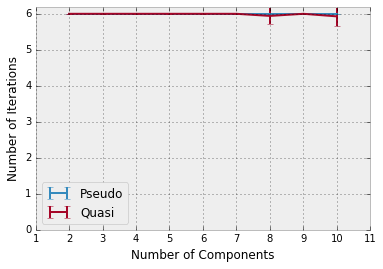

In [10]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('bmh')
ax = plt.figure()
plt.errorbar(np.arange(2, max_comps+1), np.nanmean(comp_iters_pseudo, axis=1),
             yerr=np.nanstd(comp_iters_pseudo, axis=1), label='Pseudo')
plt.errorbar(np.arange(2, max_comps+1), np.nanmean(comp_iters_quasi, axis=1),
             yerr=np.nanstd(comp_iters_quasi, axis=1), label='Quasi')
plt.ylim((0,None))
plt.xticks(list(range(1, max_comps+2)))
plt.xlabel('Number of Components')
plt.ylabel('Number of Iterations')
plt.legend(loc='best')
plt.show()

In [11]:
comp_iters_quasi

array([[  6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,
          6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.],
       [  6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,
          6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.],
       [  6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,
          6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.],
       [  6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,
          6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.],
       [  6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,
          6.,  nan,   6.,   6.,   6.,   6.,   6.,   6.,   6.],
       [  6.,   6.,   6.,   6.,   6.,   6.,   6.,  nan,   6.,   6.,   6.,
          6.,   6.,   6.,   6.,   6.,   6.,  nan,   6.,   6.],
       [  6.,   5.,  nan,  nan,   6.,   6.,   6.,   6.,   6.,   6.,   6.,
          6.,   6.,  nan,   6.,   6.,   6.,   6.,   6.,   6.],
       [  6.,   6.,  nan,  nan,   6.,   6

In [12]:
comp_iters_pseudo

array([[  6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,
          6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.],
       [  6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,
          6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.],
       [  6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,
          6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.],
       [  6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,
          6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.],
       [  6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,
          6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.],
       [  6.,   6.,   6.,   6.,   6.,   6.,  nan,  nan,   6.,   6.,   6.,
          6.,   6.,   6.,   6.,   6.,   6.,  nan,   6.,   6.],
       [  6.,  nan,  nan,  nan,   6.,   6.,   6.,   6.,   6.,   6.,   6.,
          6.,   6.,  nan,   6.,   6.,   6.,   6.,   6.,   6.],
       [  6.,  nan,  nan,  nan,   6.,   6

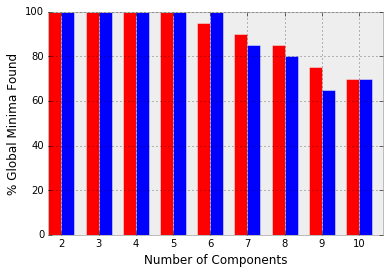

In [13]:
ind = np.arange(2, num_comps+1)  # the x locations for the groups
width = 0.35       # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(ind, 100*np.invert(np.isnan(comp_iters_quasi)).sum(1)/comp_iters_quasi.shape[-1],
                width, color='r', label='Quasi')
rects2 = ax.bar(ind + width, 100*np.invert(np.isnan(comp_iters_pseudo)).sum(1)/comp_iters_pseudo.shape[-1],
                width, color='b', label='Pseudo')
# add some text for labels, title and axes ticks
ax.set_xticks(ind + width)
ax.set_xticklabels(tuple(ind))
ax.set_xlabel('Number of Components')
ax.set_ylabel('% Global Minima Found')
#plt.legend(loc='best')
plt.show()